In [1]:
import numpy as np
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

env = gym.make('MountainCarContinuous-v0')

/home/eek31/Documents/openai/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
# preprocessing
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [3]:
import math

In [4]:
import numpy as np

theta = np.array([[1, 2, 3], [1, 2, 3]])
x = np.array([1, 0, 1])
theta, x, theta @ x

θ = np.zeros((2, 3))  # np.random.rand(400,)
Σ = np.eye(2)
np.random.multivariate_normal(θ@x, Σ)
theta @ x, np.outer(theta@x, x), theta

x ** 2, np.sqrt(x), x/(x+1)

(array([1, 0, 1]), array([1., 0., 1.]), array([0.5, 0. , 0.5]))

In [5]:
class PolicyEstimator():
    def __init__(self, α = 0.01):
        self.θ = np.zeros(400, ) #np.random.rand(400,)
        self.σ = 1
        self.α = α
        
        self.losses = []

        self.v_dθ = np.zeros(400,)
        self.β = 0.9
        self.ε = 1e-10
        
    def mu_state(self, state):
        mu = self.θ @ state
        
        return mu
    
    def reset(self):
        self.v_dθ = np.zeros(400,)
        
    def predict(self, state):
        mu = self.mu_state(state)
        
        action = np.random.normal(mu, self.σ, size=(1,))
        action = np.clip(action, env.action_space.low[0], env.action_space.high[0])

        return action
    
    def update(self, state, target, action):
        mu = self.mu_state(state)

        # track losses
        loss = (-0.5*(((action - mu)/self.σ)**2) - np.log(np.sqrt(2*math.pi))) * target
        self.losses.append(loss)
        
        # update θ
        dloss = -((action - mu)/(self.σ**2)) * state * target
#         # minimize SGD
#         self.θ -= self.α * dloss
        # minimize RMSPROP
        self.v_dθ = self.β * self.v_dθ + (1 - self.β) * (dloss**2) 
        self.θ -= self.α * dloss/(np.sqrt(self.v_dθ) + self.ε)
        
#         print(action, self.predict(state))
#         print()
#         print("PolicyEstimator", loss, 0.5*(((self.predict(state) - self.mu_state(state))/self.σ)**2) * target)

In [6]:
from scipy.spatial import distance

In [7]:
class ValueEstimator():
    def __init__(self, α = 0.1):
        self.w = np.zeros(400, ) #np.random.rand(400,)
        self.α = α
        self.losses = []
        
        self.v_dw = np.zeros(400,)
        self.β = 0.9
        self.ε = 1e-10
        
    def reset(self):
        self.v_dw = np.zeros(400,)
        
    def predict(self, state):
        value = self.w @ state
        return value
    
    def update(self, state, target):
        value = self.predict(state)
        
        # update loss
        loss = distance.euclidean(value, target)
        self.losses.append(loss)
        
        # update w
        dloss = 2*(value - target)*state
#         # minimize SGD
#         self.w -= self.α * dloss
        # minimize RMSPROP
        self.v_dw = self.β * self.v_dw + (1 - self.β) * (dloss**2) 
        self.w -= self.α * dloss/(np.sqrt(self.v_dw) + self.ε)
        
#         print("ValueEstimator", loss, distance.euclidean(self.predict(state), target))


In [8]:
from tqdm import tqdm_notebook
import time

In [9]:
policy_estimator = PolicyEstimator(α=0.001)
value_estimator = ValueEstimator(α=0.1)

In [10]:
"""
TRAIN
"""

num_episodes = 20
num_steps = 1000
discount_factor=0.95

for i in range(num_episodes):
#     policy_estimator.reset()
#     value_estimator.reset()
    
    # set v_dw and v_dθ to 0
    state = env.reset()
    state = featurize_state(state)

    for t in tqdm_notebook(range(num_steps)):
        if i % 10 == 0:
            env.render()
        # take action
        action = policy_estimator.predict(state)

        # execute action
        next_state, reward, done, _ = env.step(action)
        next_state = featurize_state(next_state)

        # calculate TD target
        value_now = value_estimator.predict(state)
        value_next = value_estimator.predict(next_state)
        td_target = reward + discount_factor * value_next
        td_error = td_target - value_now

        # update the value estimator
        value_estimator.update(state, td_target)
        # update the policy estimator
        policy_estimator.update(state, td_error, action)

#         print(state, action, value_now, value_next, td_error)

        if done & (t <= 900):
#             env.render()
#             time.sleep(1)
#             env.close()
            
            break

        state = next_state
    
    env.close()

In [20]:
"""
TEST
"""

num_steps = 1000

state = env.reset()
state = featurize_state(state)

policy_estimator.σ = 0
for t in tqdm_notebook(range(num_steps)):
    env.render()
    
    # take action
    action = policy_estimator.predict(state)

    # execute action
    next_state, reward, done, _ = env.step(action)
    next_state = featurize_state(next_state)


    if done & (t < 900):
        break

    state = next_state
    time.sleep(0.01)

env.close()

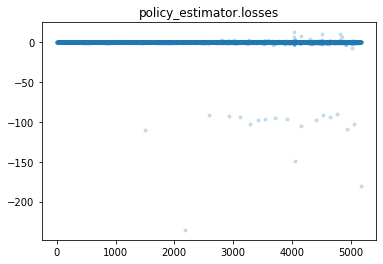

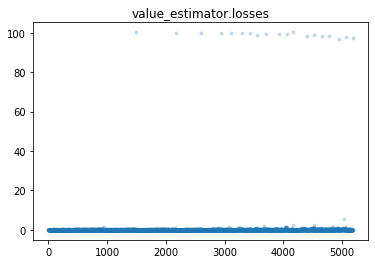

100.21576912361047

In [12]:
plt.plot(policy_estimator.losses, ".", alpha=0.2)
plt.title("policy_estimator.losses")
plt.show()

plt.plot(value_estimator.losses, ".", alpha=0.2)
# plt.ylim((0, 2))
plt.title("value_estimator.losses")
plt.show()

max(value_estimator.losses)

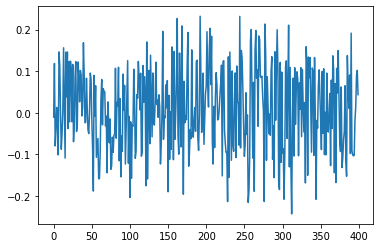

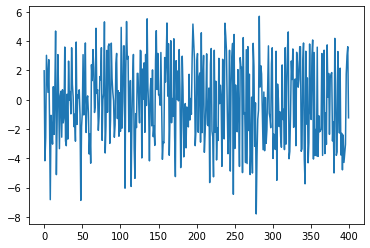

In [13]:
plt.plot(policy_estimator.θ)
plt.show()

plt.plot(value_estimator.w)
plt.show()

In [14]:
# need to decay learning rate if we always want to converge

In [15]:
%matplotlib inline

In [16]:
# """
# Visualize Value Network
# """

# from mpl_toolkits.mplot3d import Axes3D 
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# for i in range(0, 20, 1):
#     for j in range(0, 20, 1):
#         s = featurize_state([i/10, j/10])
#         z = value_estimator.predict(s)
#         ax.scatter(i, j, z, 'o', c='b', alpha=0.5)
        
# # plt.show()

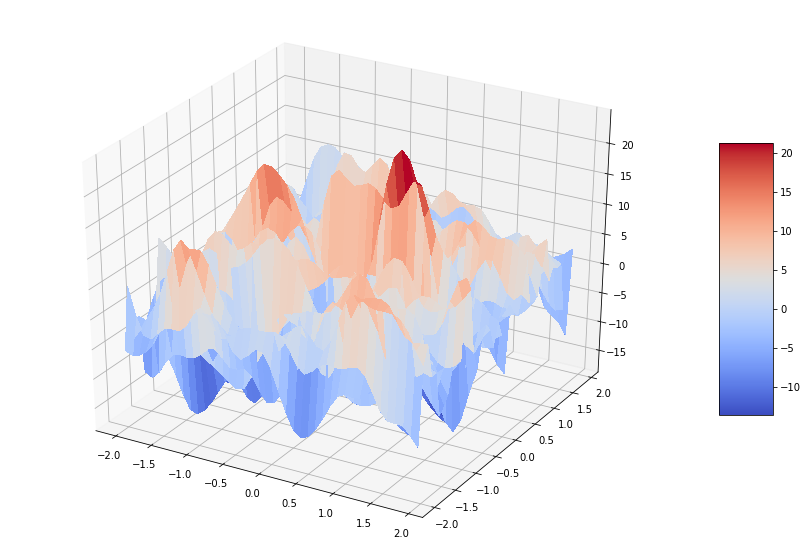

In [21]:
from mpl_toolkits.mplot3d import Axes3D 

"""
Illustrate Value Network
proxy to objective function
"""

from matplotlib import cm

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-2, 2, 0.1)
Y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(X, Y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = value_estimator.predict(featurize_state([X[i,j], Y[i,j]]))


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


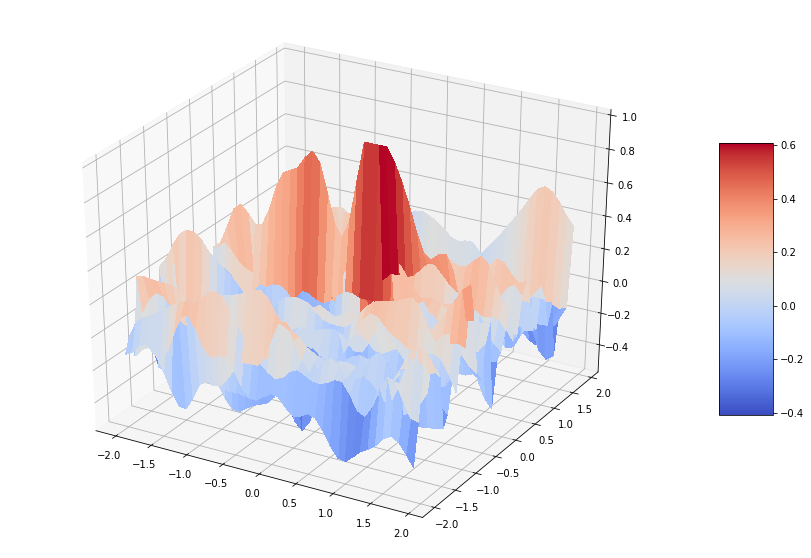

In [22]:
"""
Illustrate Policy Network
proxy to objective function
"""

from matplotlib import cm

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-2, 2, 0.1)
Y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(X, Y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = policy_estimator.predict(featurize_state([X[i,j], Y[i,j]]))


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
